### Tests

In [1]:
import sys, os
sys.path.append('../../src')

import astropy.coordinates as coord

from astropy.io.votable import parse
from astropy.table import Table
from astropy import units as u

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil
import gaia_utils as gu
from sklearn.cluster import KMeans

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)

In [2]:
from astroquery.gaia import Gaia

# tables = Gaia.load_tables(only_names=True)

#for table in (tables):
#    print (table.get_qualified_name())
    

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
c = coord.SkyCoord.from_name("M47")
c = coord.SkyCoord.from_name("NGC 2682")
c = coord.SkyCoord.from_name("NGC 2232")
radius = 0.5

queryaql = "SELECT * FROM gaiadr2.gaia_source WHERE \
CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS' \
,%f ,%f,%f))=1;"%(c.ra.deg+radius/10.,c.dec.deg+radius/10.,radius)

# job = Gaia.launch_job_async( queryaql, dump_to_file=True)
# print (job)

# r = job.get_results()


In [4]:
## Filter the data
##

def plot_check(a1, a2, ifinal):
    "check the filltering"
    
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)

# ax.scatter(cluster_candidates["ra"], cluster_candidates["dec"], s=1, c="#000000")
    print(len(a1))
    print(len(a2))
    
    axarr[0,0].scatter(a1, a2, s=1, c="#000000")
    axarr[0,0].set_xlabel("a1")
    axarr[0,0].set_ylabel("a2")
    axarr[0,0].set_ylim([0,2000])

    axarr[0,1].scatter(a1[ifinal], a2[ifinal], s=1, c="#000000")
    axarr[0,1].set_xlabel("a1[ifinal]")
    axarr[0,1].set_ylabel("a2[ifinal]")

    plt.show()
    
def filter_data(lgal, bgal, distance, vra, vdec, cartesian = False, dist_range = [0., 2000], vra_range = [-200,200], vdec_range = [-200.,200]):
    "filter the data applying the range and return the sklearn-centric array"
    
    i1 = np.where((distance >= dist_range[0]) & (distance < dist_range[1]))
    i2 = np.where((vra >= vra_range[0]) & (vra < vra_range[1]))
    i12 = np.intersect1d(i1,i2)
    i3 = np.where((vdec >= vdec_range[0]) & (vdec < vdec_range[1]))
    ifinal = np.intersect1d(i12,i3)
    
    # plot_check(lgal,vra,ifinal)
    
    datask = np.zeros((len(ifinal),5))
    
    if cartesian:
        xx, yy, zz = convert_to_cartesian(lgal[ifinal], bgal[ifinal], distance[ifinal])
        datask[:,0] = xx
        datask[:,1] = yy
        datask[:,2] = zz
        datask[:,3] = vra[ifinal]
        datask[:,4] = vdec[ifinal]
    else:
        datask[:,0] = lgal[ifinal]
        datask[:,1] = bgal[ifinal]
        datask[:,2] = distance[ifinal]
        datask[:,3] = vra[ifinal]
        datask[:,4] = vdec[ifinal]
    
    return(datask)
    
    

In [5]:
## plot2D and plot3D


def plot2d_labels(a1,a2,labels,nclusterk,centroid,xylab = ["a1","b1"],title = "Title", clustername= "NGC"):
    figname = "%s-2Dkmeans-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3           
    f, axarr = plt.subplots(nrow, ncol)

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) - 1
        col = i % 3
        axarr[row,col].scatter(a1[ilabel],a2[ilabel], s=1, c="#000000")
        axarr[row,col].set_xlabel(xylab[0])
        axarr[row,col].set_ylabel(xylab[1])
        
        txt = "Stars:%d Dist:%3.1f Vra:%3.1f Vdec:%3.1f"%(len(ilabel), centroid[i][2],centroid[i][3],centroid[i][4])
        axarr[row,col].text(-0.1,1.02, txt, size=12, ha="left", 
         transform=axarr[row,col].transAxes)
        
    plt.savefig(figname)
    plt.show()

    
def plot3d_labels(a1,a2,a3,labels,nclusterk,centroid,xylab = ["X","Y","Z"],title = "Title", clustername= "NGC"):
    figname = "%s-3Dkmeans-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3
    
    fig = plt.figure()

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) 
        col = i % 3 + 1
        axarr = fig.add_subplot(nrow,ncol,i+1, projection='3d')
        axarr.scatter(a1[ilabel],a2[ilabel],a3[ilabel], c="r",marker ="*")
        axarr.set_xlabel(xylab[0])
        axarr.set_ylabel(xylab[1])
        axarr.set_zlabel(xylab[2])
    
    plt.savefig(figname)
    plt.show()

In [6]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgal[i]*u.degree, b=bgal[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    return(xx,yy,zz)

('solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

/home/stephane/.local/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/stephane/.local/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/stephane/.local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


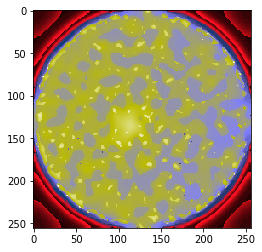

## Total stars: 70274
## Stars selected: 37627
## computing k-means...
## Centroids:
[[ 215.57561589   32.05551456 1518.22386093  -20.57041974  -25.48309283]
 [ 215.56943815   32.09680658  640.95305607  -13.56078188  -16.89698912]
 [ 215.59292164   32.12078034  373.39118189  -10.64293185  -15.73180722]
 [ 215.55200276   32.0838156  1040.1011474   -17.37178517  -20.67343227]
 [ 215.59404329   32.07455364 1701.3873079   -20.58057748  -27.9422646 ]
 [ 215.58002756   32.08937646 1191.9058574   -18.15232668  -21.2800932 ]
 [ 215.59113727   32.10775032  214.72489153   -9.54366459  -15.60682288]
 [ 215.58638898   32.08182288  773.75207899  -15.81386607  -19.06757688]
 [ 215.55686026   32.0958632   508.53592314  -10.93652798  -16.62841463]
 [ 215.557304     32.11368992 1350.46879311  -18.42579211  -24.10365472]
 [ 215.57358336   32.0900786  1892.95039007  -21.12792606  -31.20855077]
 [ 215.61723355   32.07849643  898.61155689  -23.84471889  -17.44544492]]
## Label: 0, 2510 stars
## Label: 1, 3

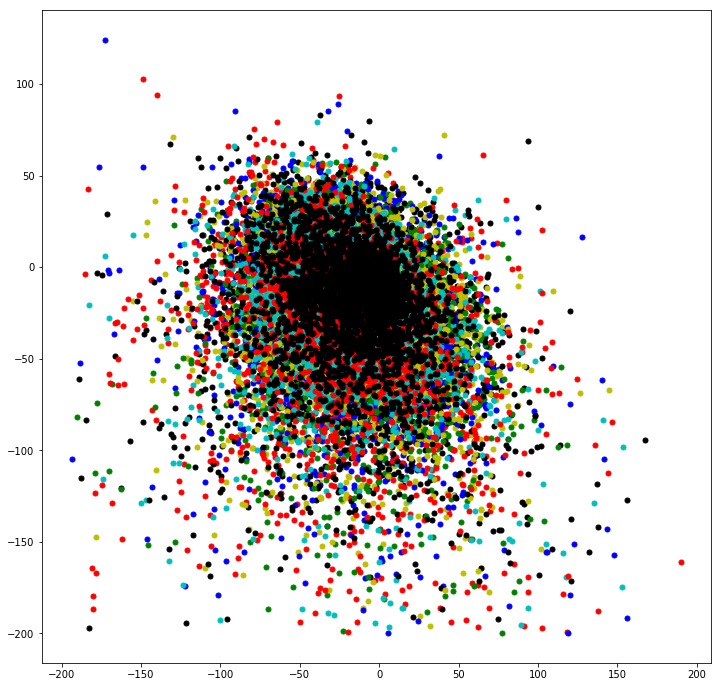

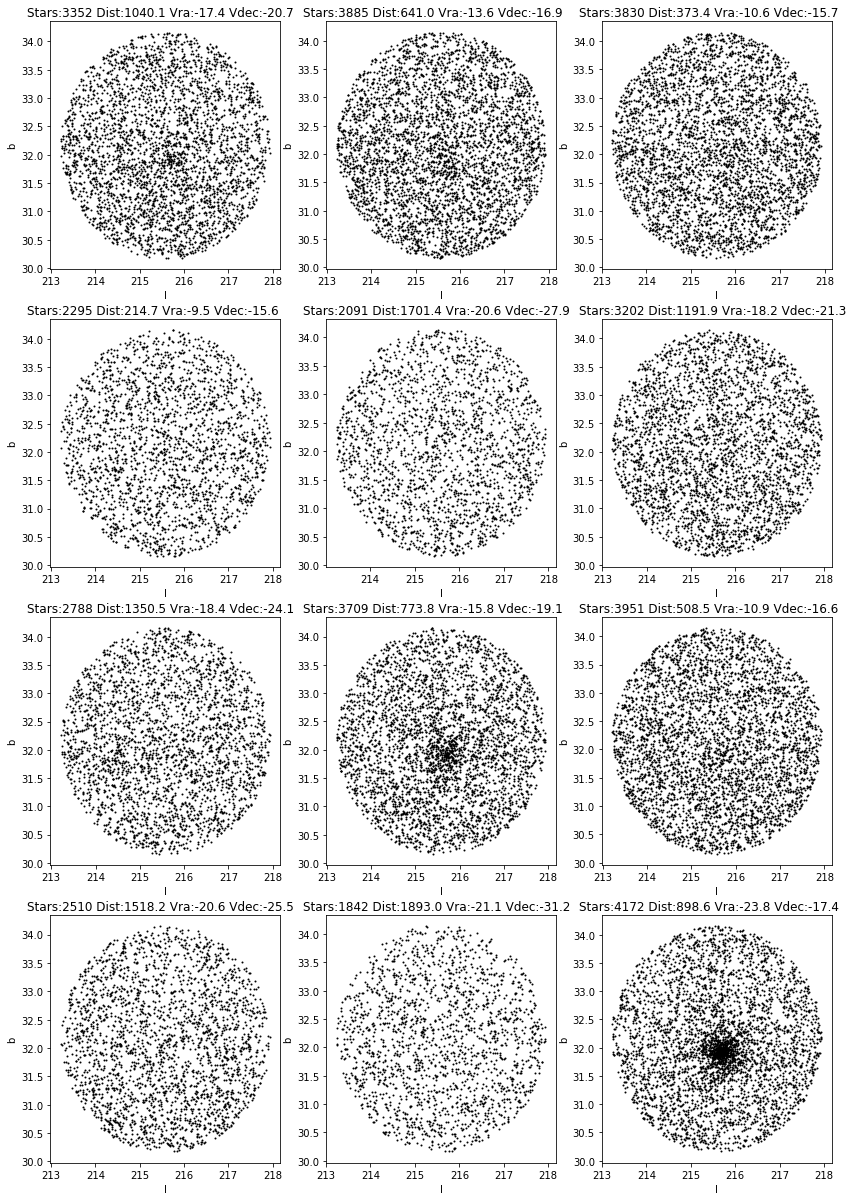

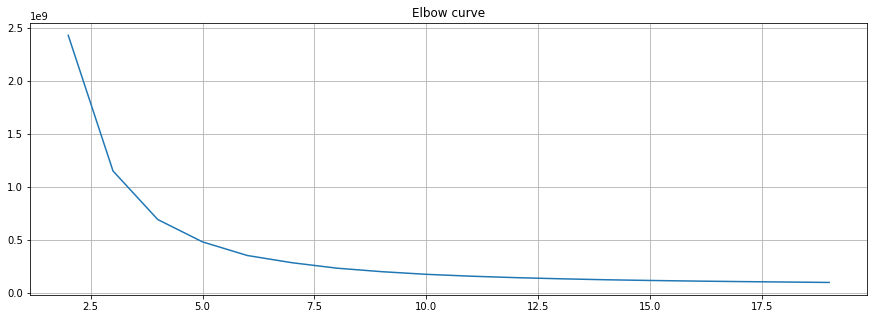

In [7]:
## Reading the votable

#voname = "m47_off.vot"
#voname = "ngc2232.vot"
voname = "ngc2682_2deg.vot"

votable = parse(voname)

for table in votable.iter_tables():
    data = table.array
    print(data.dtype.names)
    
lgal = data['l']
bgal = data['b']
pmas = data['parallax']
distance = 1000. / np.ma.filled(pmas, -9999.)
pmra = np.ma.filled(data['pmra'], -9999999.)
pmdec= np.ma.filled(data['pmdec'],-9999999.)
vdec = 4.74 * pmdec / pmas   ##?
vra  = 4.74 * pmra  / pmas

gaia = gu.gaiaSet(data)
im , imf = gaia.sampling_filtering(data['l'],data['b'], 256, 3.0)

plt.imshow(imf, cmap = 'gist_stern')
plt.show()

print("## Total stars: %d"%(len(lgal)))

## mashing the data ...
##


# datask = np.zeros((len(vra),5))
datask = filter_data(lgal,bgal,distance,vra,vdec ,cartesian = False)

print("## Stars selected: %d"%(len(datask[:,0])))


## fitted cluster in k-means
nclust = 12

print("## computing k-means...")
kmeans = KMeans(n_clusters=nclust, max_iter = 500, n_init = 50)
kmeans.fit(datask)

centroid = kmeans.cluster_centers_
labels = kmeans.labels_

print("## Centroids:")
print(centroid)
#print(labels)
for i in range(nclust):
    nstar = len(np.where(labels == i)[0])
    print("## Label: %d, %d stars"%(i,nstar))


colors = ["r.","k.","g.","y.","b.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c."]
rcParams['figure.figsize'] = 12, 12

for i in range(nclust):
    ilabel = np.where(labels == i)[0]
    plt.plot(datask[ilabel,3],datask[ilabel,4],colors[i],markersize=10)
    
plt.show()


## plot the different clusters

a1 = datask[:,0]
a2 = datask[:,1]
plot2d_labels(a1,a2,labels,nclust,centroid,xylab = ["l","b"],title = "Title", clustername= "NGC")

lgalf = datask[:,0]
bgalf = datask[:,1]
distf = datask[:,2]
vraf  = datask[:,3]
vdecf  = datask[:,4]
# xx ,yy , zz = convert_to_cartesian(lgalf,bgalf,distf)
# plot3d_labels(xx,yy,zz,labels,nclust,centroid,xylab = ["X","Y","Z"],title = "Title", clustername= "NGC")


### Elbow method
X = datask
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

    